In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# First read in the unvalidated GALAH DR4 file
galah_dr4_raw = Table.read('../analysis_products/galah_dr4_allspec_not_validated.fits')
galah_dr4_raw['tmass_id'] = np.array(galah_dr4_raw['tmass_id'][:,0],dtype='str')

In [3]:
# Then read in APOGEE DR17
apogee_dr17 = Table.read('../../Surveys/APOGEE_DR17/APOGEE_DR17.fits')
apogee_dr17['tmass_id'] = apogee_dr17['TMASS_ID']

In [4]:
# Join them with the tmass_id keyword
joined = join(galah_dr4_raw, apogee_dr17, keys='tmass_id')

In [5]:
common_keys = dict()
common_keys['teff'] = 'TEFF'
common_keys['logg'] = 'LOGG'
common_keys['fe_h'] = 'FE_H'
common_keys['vmic'] = 'VMICRO'
common_keys['vsini'] = 'VSINI'
common_keys['c_fe'] = 'C_FE'
common_keys['n_fe'] = 'N_FE'
common_keys['o_fe'] = 'O_FE'
common_keys['na_fe'] = 'NA_FE'
common_keys['mg_fe'] = 'MG_FE'
common_keys['al_fe'] = 'AL_FE'
common_keys['si_fe'] = 'SI_FE'
common_keys['k_fe'] = 'K_FE'
common_keys['ca_fe'] = 'CA_FE'
common_keys['ti_fe'] = 'TIII_FE'
common_keys['v_fe'] = 'V_FE'
common_keys['cr_fe'] = 'CR_FE'
common_keys['mn_fe'] = 'MN_FE'
common_keys['co_fe'] = 'CO_FE'
common_keys['ni_fe'] = 'NI_FE'
common_keys['cu_fe'] = 'CU_FE'
common_keys['ce_fe'] = 'CE_FE'

In [6]:
def plot_comparison_hrd(joined, name_literature = 'APOGEE DR17'):
    f, gs = plt.subplots(1,4,figsize=(15,5))
    
    # First panel: GALAH DR4
    ax = gs[0]
    ax.set_xlabel('Teff / K (GALAH DR4)')
    ax.set_ylabel('log (g / cm s-2) (GALAH DR4)')
    ax.scatter(
        joined['teff'],
        joined['logg'],
        c = joined['fe_h'],
        s=1,cmap='plasma',vmin=-2,vmax=0.5
    )
    ax.set_xlim(7800,3200)
    ax.set_ylim(5,0)
    
    # Second Panel: Literature HRD
    ax = gs[1]
    ax.set_xlabel('Teff / K ('+name_literature+')')
    ax.set_ylabel('log (g / cm s-2) ('+name_literature+')')
    ax.scatter(
        joined[common_keys['teff']],
        joined[common_keys['logg']],
        c = joined[common_keys['fe_h']],
        s=1,cmap='plasma',vmin=-2,vmax=0.5
    )
    ax.set_xlim(7800,3200)
    ax.set_ylim(5,0)

    # Third Panel: Difference in Teff
    ax = gs[2]
    ax.set_xlabel('Teff / K ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$Teff / K (GALAH DR4 - '+name_literature+')')
    ax.axhline(0,c='r',lw=1,ls='dashed')
    ax.set_ylim(-500,500)
    ax.scatter(
        joined[common_keys['teff']],
        joined['teff'] - joined[common_keys['teff']],
        s=1,c='k'
    )

    # Fourth Panel: Difference in logg
    ax = gs[3]
    ax.set_xlabel('log (g / cm s-2) ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$log (g / cm s-2) (GALAH DR4 - '+name_literature+')')
    ax.axhline(0,c='r',lw=1,ls='dashed')
    ax.set_ylim(-0.5,0.5)
    ax.scatter(
        joined[common_keys['logg']],
        joined['logg'] - joined[common_keys['logg']],
        s=1,c='k'
    )
    plt.tight_layout()

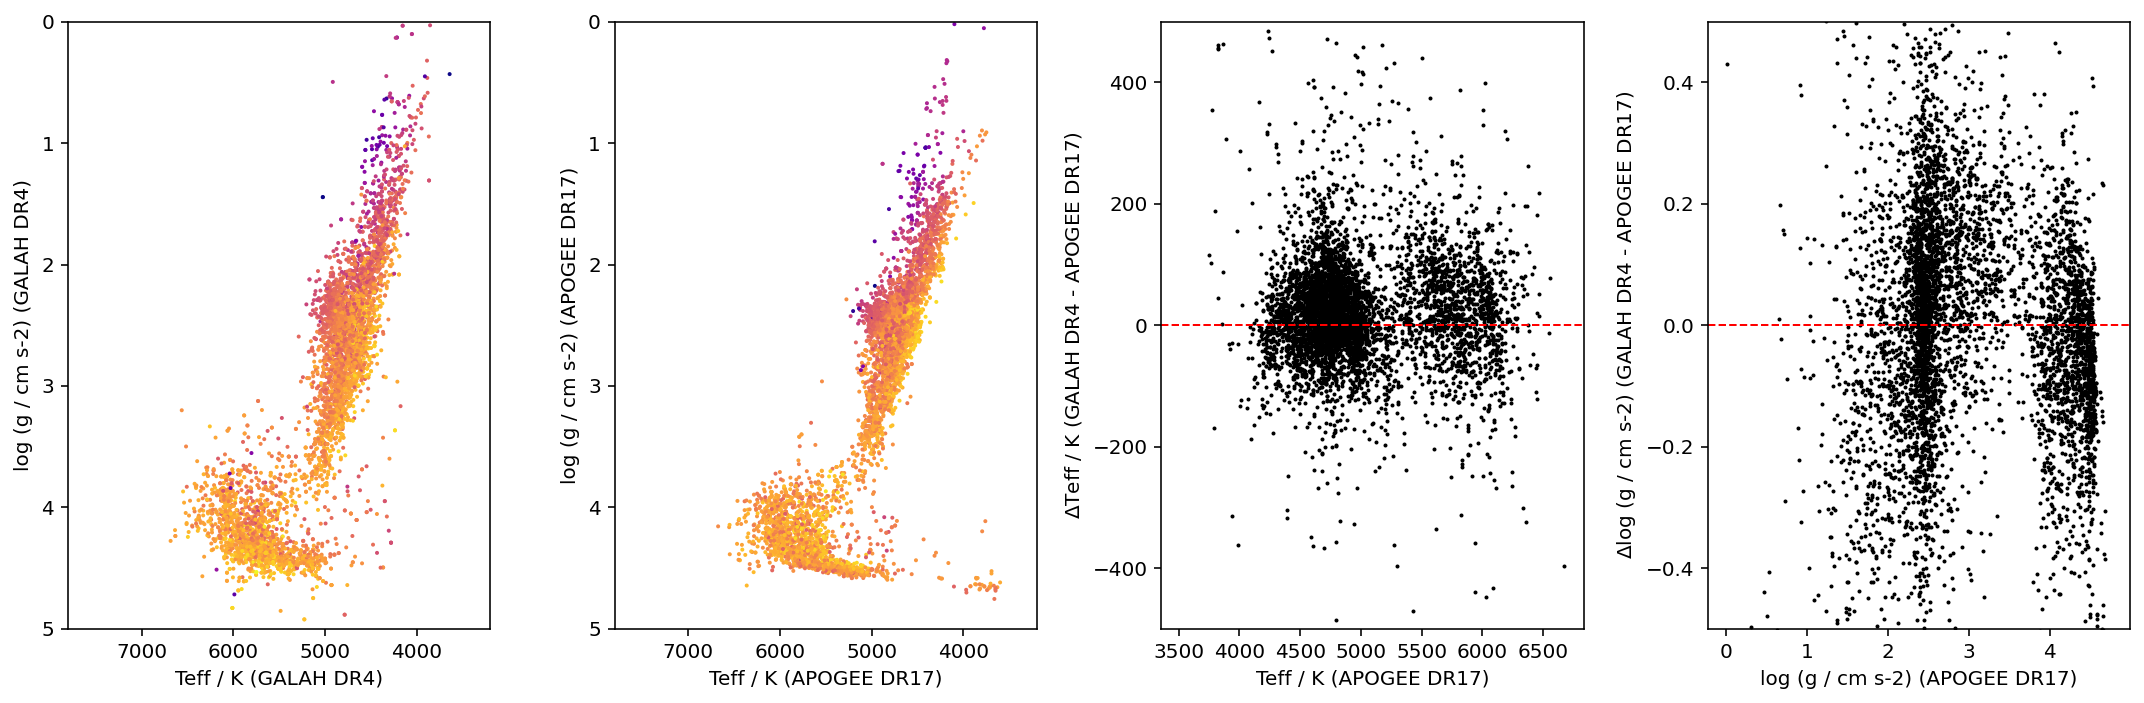

In [7]:
plot_comparison_hrd(joined)

In [8]:
def plot_comparison_stellar_parameters(joined, name_literature = 'APOGEE DR17'):
    f, gs = plt.subplots(1,3,figsize=(15,5))
    
    apply_quality_cuts = (
        np.isfinite(joined['teff']) &
        np.isfinite(joined[common_keys['teff']]) &
        np.isfinite(joined['logg']) &
        np.isfinite(joined[common_keys['logg']]) &
        np.isfinite(joined['fe_h']) &
        np.isfinite(joined[common_keys['fe_h']])
    )
    
    # First panel: Teff
    ax = gs[0]
    ax.set_xlabel(r'Teff / K ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$Teff / K ('+name_literature+' - GALAH_DR4)')
    ax.hist2d(
        joined[common_keys['teff']][apply_quality_cuts],
        joined[common_keys['teff']][apply_quality_cuts]-joined['teff'][apply_quality_cuts],
        bins=(np.linspace(3500,6500,100),np.linspace(-500,500,100)),
        cmin=1
    )
    print('Teff',np.percentile(joined[common_keys['teff']][apply_quality_cuts]-joined['teff'][apply_quality_cuts],q=[50]))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    # Second panel: logg
    ax = gs[1]
    ax.set_xlabel(r'log (g / cm s-2) ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$log (g / cm s-2) ('+name_literature+' - GALAH_DR4)')
    ax.hist2d(
        joined[common_keys['logg']][apply_quality_cuts],
        joined[common_keys['logg']][apply_quality_cuts]-joined['logg'][apply_quality_cuts],
        bins=(np.linspace(-1,5.5,100),np.linspace(-1,1,100)),
        cmin=1
    )
    print('logg',np.percentile(joined[common_keys['logg']][apply_quality_cuts]-joined['logg'][apply_quality_cuts],q=[50]))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    # First panel: [Fe/H]
    ax = gs[2]
    ax.set_xlabel(r'[Fe/H] ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$[Fe/H] ('+name_literature+' - GALAH_DR4)')
    ax.hist2d(
        joined[common_keys['fe_h']][apply_quality_cuts],
        joined[common_keys['fe_h']][apply_quality_cuts]-joined['fe_h'][apply_quality_cuts],
        bins=(np.linspace(-3,1,100),np.linspace(-0.5,0.5,100)),
        cmin=1
    )
    print('[Fe/H]',np.percentile(joined[common_keys['fe_h']][apply_quality_cuts]-joined['fe_h'][apply_quality_cuts],q=[50]))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    plt.tight_layout()

Teff [-17.70068359]
logg [-0.0063343]
[Fe/H] [0.0059287]


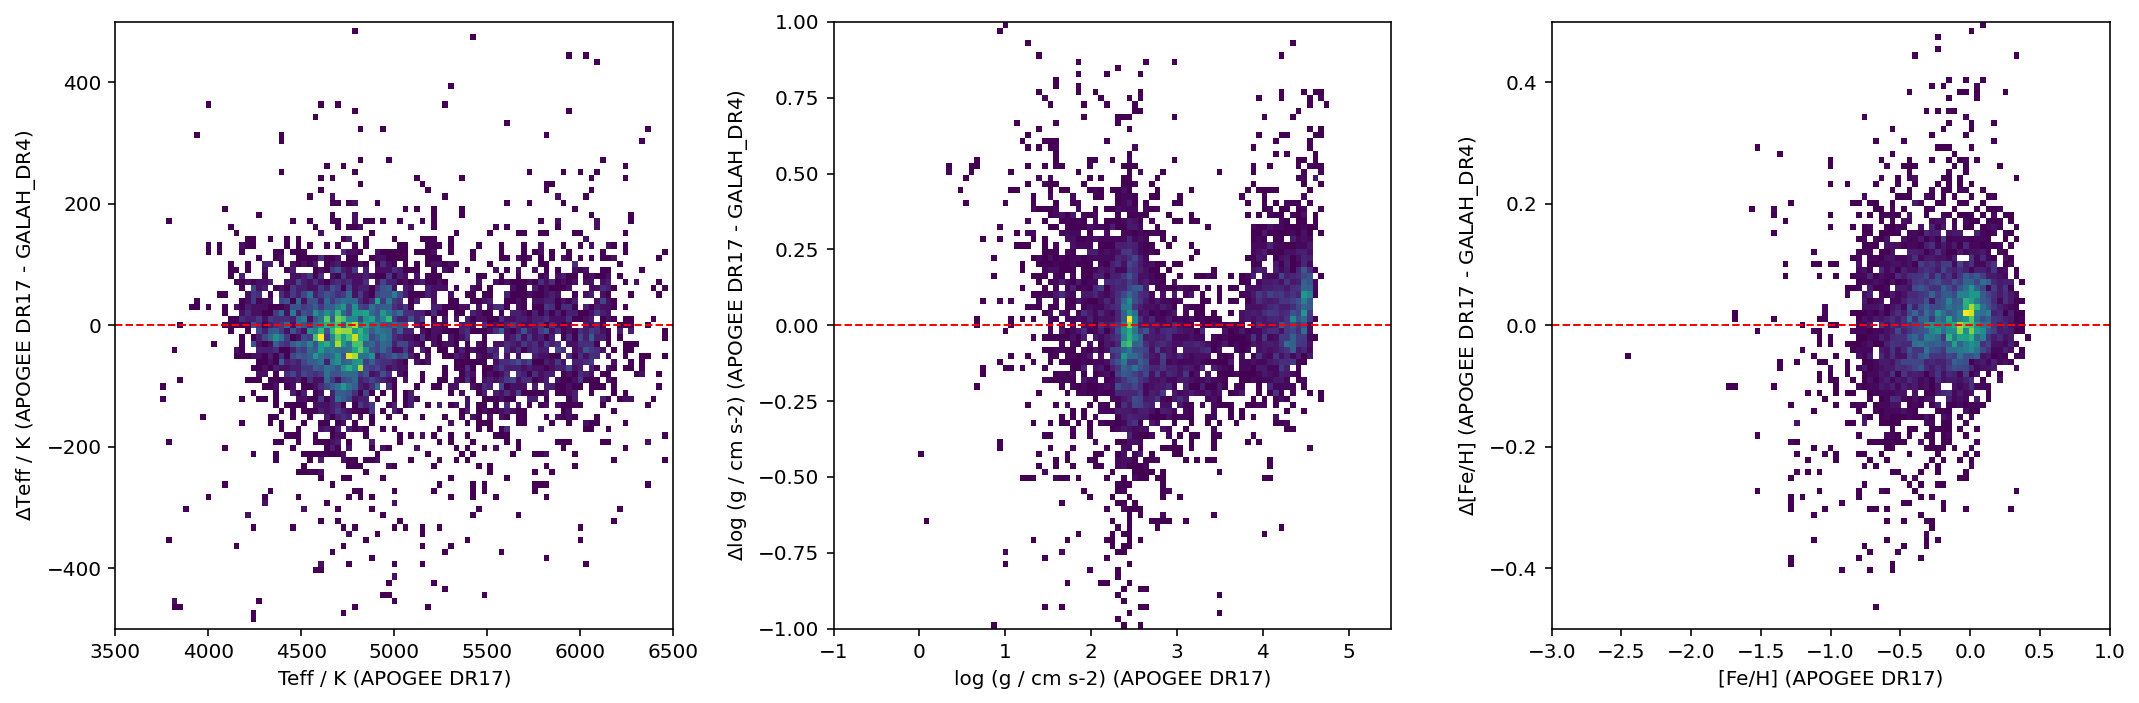

In [9]:
plot_comparison_stellar_parameters(joined)

In [10]:
def plot_comparison_xfe(joined, element = 'C', name_literature = 'APOGEE DR17'):
    f, gs = plt.subplots(1,3,figsize=(10,3),sharey=True)
    
    apply_quality_cuts = (
        (joined['flag_'+element.lower()+'_fe'] == 0) &
        np.isfinite(joined['fe_h']) &
        np.isfinite(joined[element.lower()+'_fe']) &
        np.isfinite(joined[common_keys['fe_h']]) &
        np.isfinite(joined[common_keys[element.lower()+'_fe']])
    )
    
    xbins = np.linspace(-2.5,0.75,100)
    if element == 'Li':
        ybins = np.linspace(-2,4,100)
    elif element in ['O','Ba','Y']:
        ybins = np.linspace(-2,2,100)
    else:
        ybins = np.linspace(-1,1,100)
    
    # First panel: GALAH DR4 [Fe/H] vs. [X/Fe]
    ax = gs[0]
    ax.set_xlabel('[Fe/H] (GALAH DR4)')
    ax.set_ylabel('['+element+'/Fe] (GALAH DR4)')
    ax.hist2d(
        joined['fe_h'][apply_quality_cuts],
        joined[element.lower()+'_fe'][apply_quality_cuts],
        bins = (xbins,ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlim(
        np.min([
            np.min(joined['fe_h'][apply_quality_cuts])-0.1,
            np.min(joined[common_keys['fe_h']][apply_quality_cuts])-0.1
        ]),
        np.max([
            np.max(joined['fe_h'][apply_quality_cuts])+0.1,
            np.max(joined[common_keys['fe_h']][apply_quality_cuts])+0.1
        ]),
    )
    
    # Second panel: Literature [Fe/H] vs. [X/Fe]
    ax = gs[1]
    ax.set_xlabel('[Fe/H] ('+name_literature+')')
    ax.set_ylabel('['+element+'/Fe] ('+name_literature+')')
    ax.hist2d(
        joined[common_keys['fe_h']][apply_quality_cuts],
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts],
        bins = (xbins,ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlim(
        np.min([
            np.min(joined['fe_h'][apply_quality_cuts])-0.1,
            np.min(joined[common_keys['fe_h']][apply_quality_cuts])-0.1
        ]),
        np.max([
            np.max(joined['fe_h'][apply_quality_cuts])+0.1,
            np.max(joined[common_keys['fe_h']][apply_quality_cuts])+0.1
        ]),
    )
    
    # Third panel: Difference [X/Fe]
    ax = gs[2]
    ax.set_xlabel(r'$\Delta$['+element+'/Fe] ('+name_literature+' - GALAH DR4)')
    ax.set_ylabel('['+element+'/Fe] ('+name_literature+')')
    ax.hist2d(
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts],
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts],
        bins = (np.linspace(-0.5,0.5,100),ybins),cmin=1,norm=LogNorm()
    )
    
    percentiles = np.percentile(joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts],q=[16,50,84])
    mean = np.mean(joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts])
    sigma = np.std(joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts])
    text = r'${'+str(np.round(percentiles[1],decimals=2))+'}_{-'+str(np.round(percentiles[1]-percentiles[0],decimals=2))+'}^{+'+str(np.round(percentiles[2]-percentiles[1],decimals=2))+'}$,   $\mu\pm\sigma = '+str(np.round(mean,decimals=2))+'\pm'+str(np.round(sigma,decimals=2))+'$'
    ax.text(0.05,0.1,text,transform=ax.transAxes)

    apply_quality_cuts_solar = (
        apply_quality_cuts &
        (joined[common_keys[element.lower()+'_fe']] > -0.25)& 
        (joined[common_keys[element.lower()+'_fe']] < 0.25)
    )
    print(element,np.percentile(joined[common_keys[element.lower()+'_fe']][apply_quality_cuts_solar]-joined[element.lower()+'_fe'][apply_quality_cuts_solar],q=[50]))
    ax.axvline(0,c='r',lw=1,ls='dashed')
    
    plt.tight_layout()

/Users/svenbuder/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1543: RuntimeWarning: invalid value encountered in less_equal
  super().autoscale_None(np.ma.array(A, mask=(A <= 0)))
/Users/svenbuder/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/svenbuder/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


C [-0.03019332]
N [-0.02099895]
O [-0.00490813]
Na [-0.12124635]
Mg [0.02958916]
Al [-0.05510376]
Si [0.00706527]
K [0.02996171]
Ca [0.01166951]
Ti [-0.02369794]
V [-0.2060821]
Cr [0.00261748]
Mn [0.03536174]
Co [-0.084831]
Ni [0.00716388]
Ce [0.07482789]


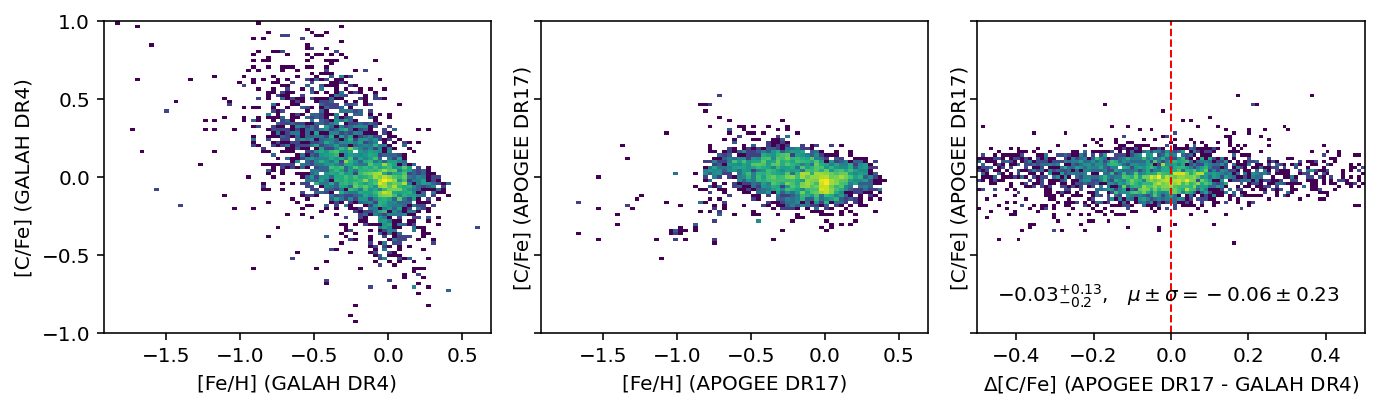

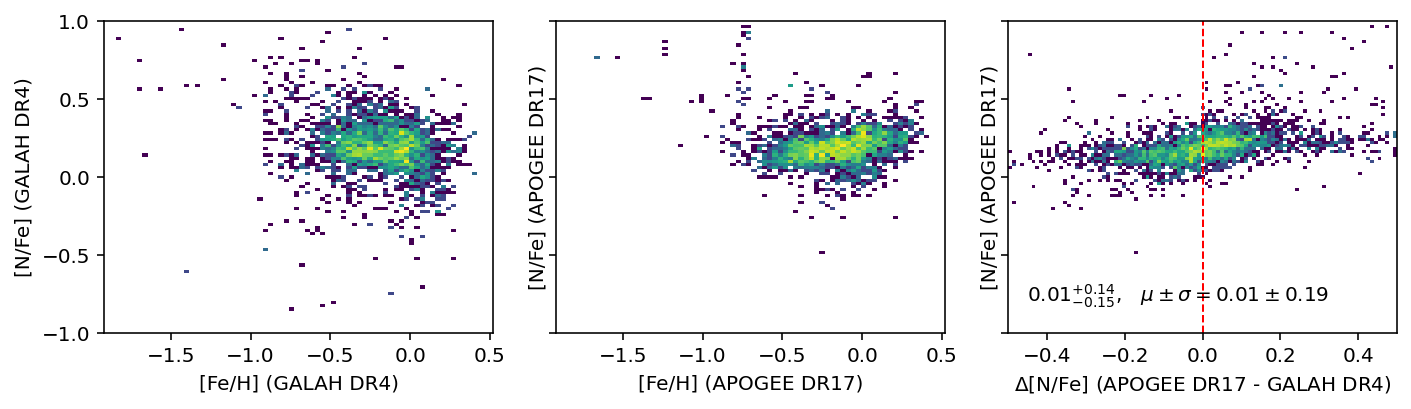

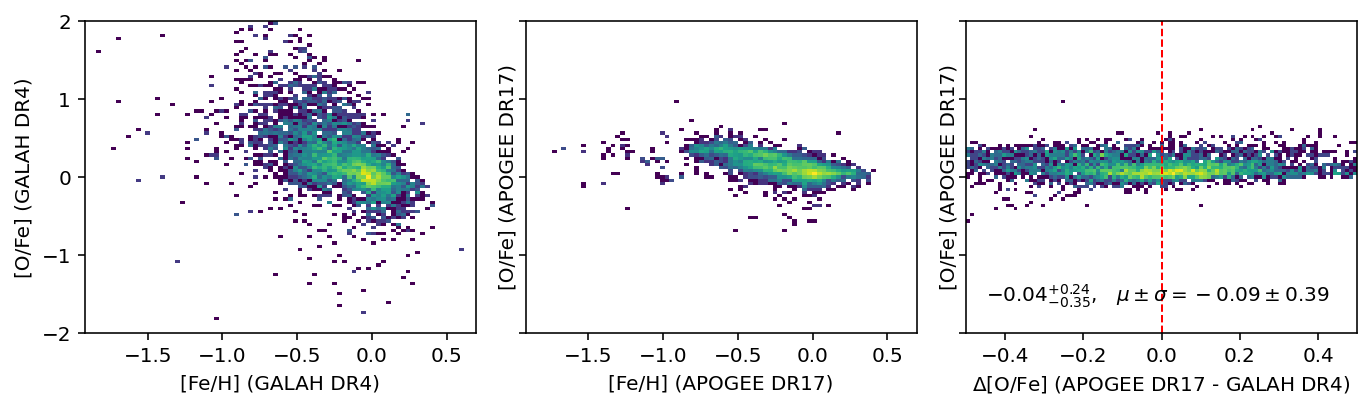

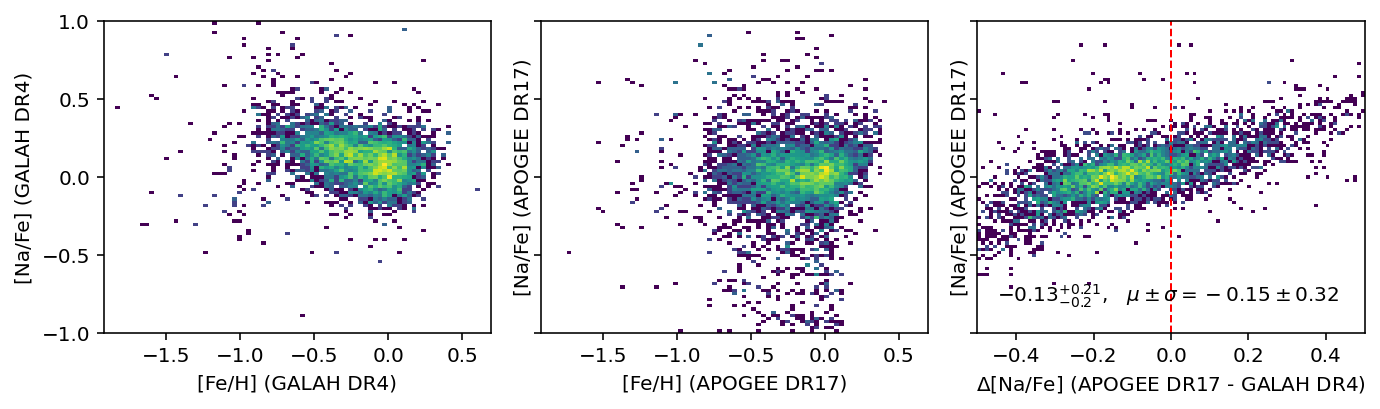

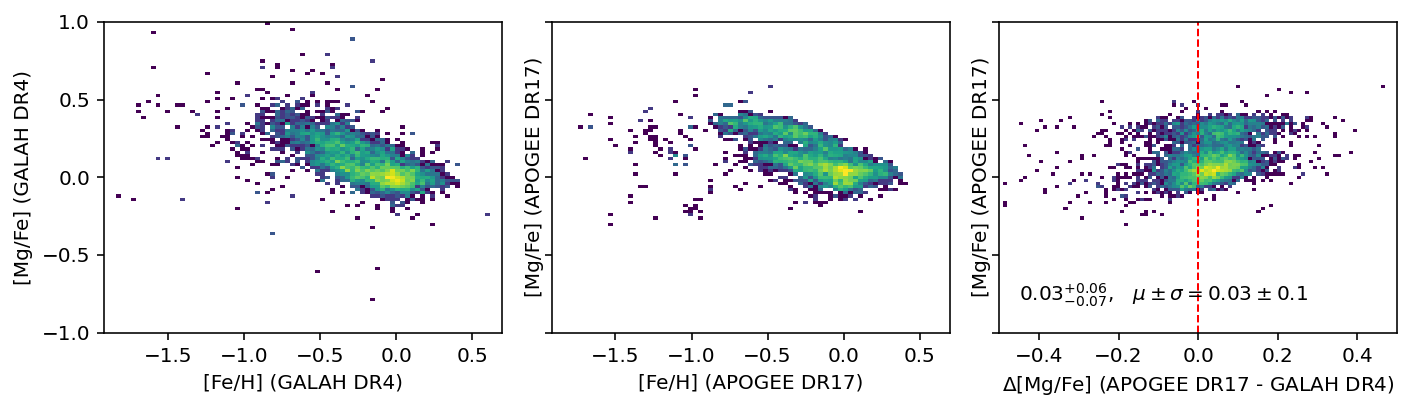

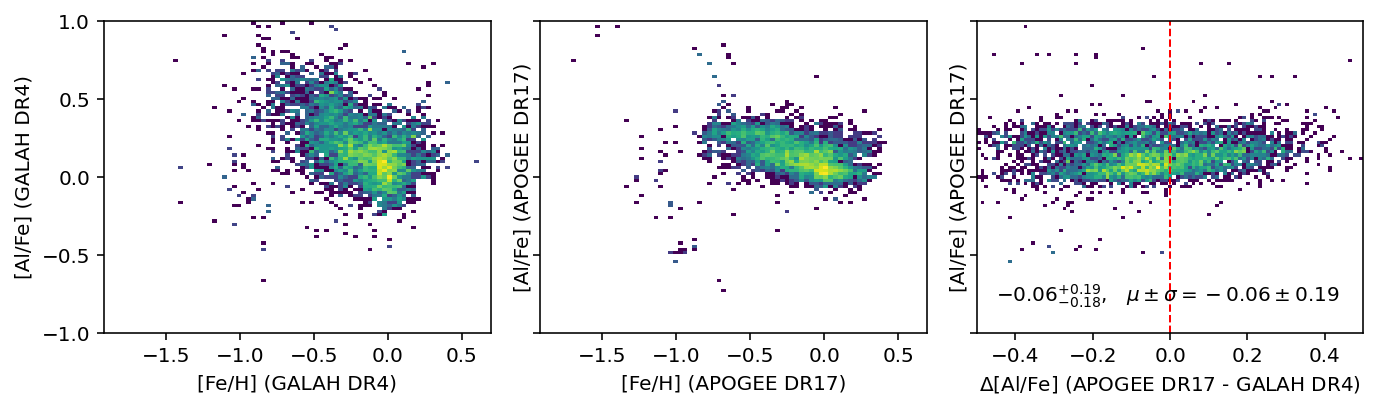

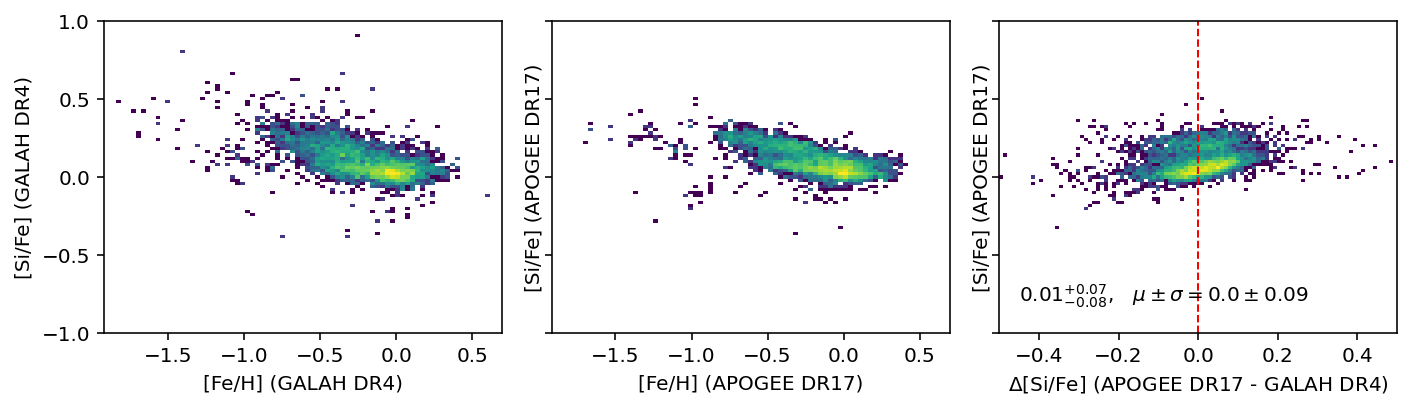

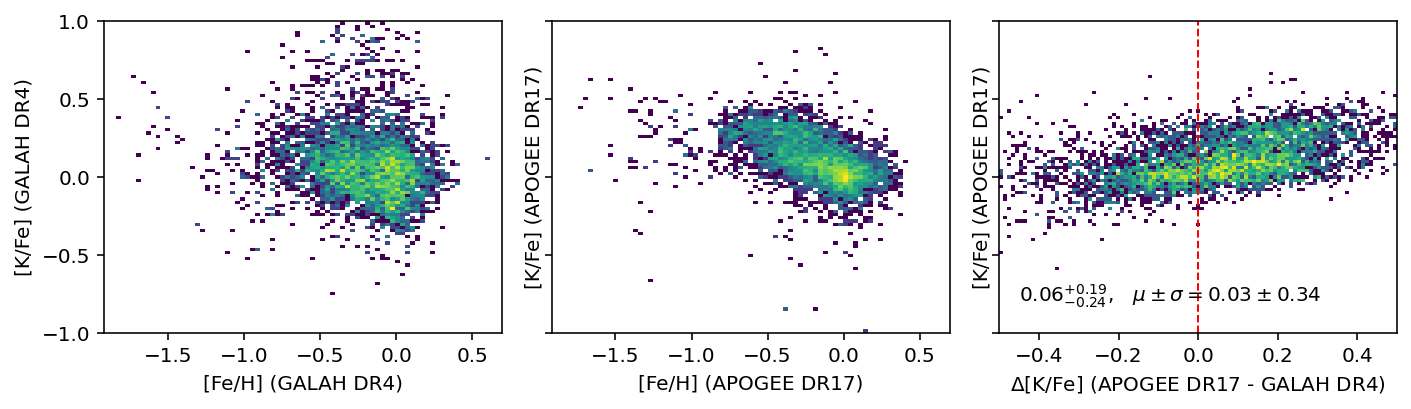

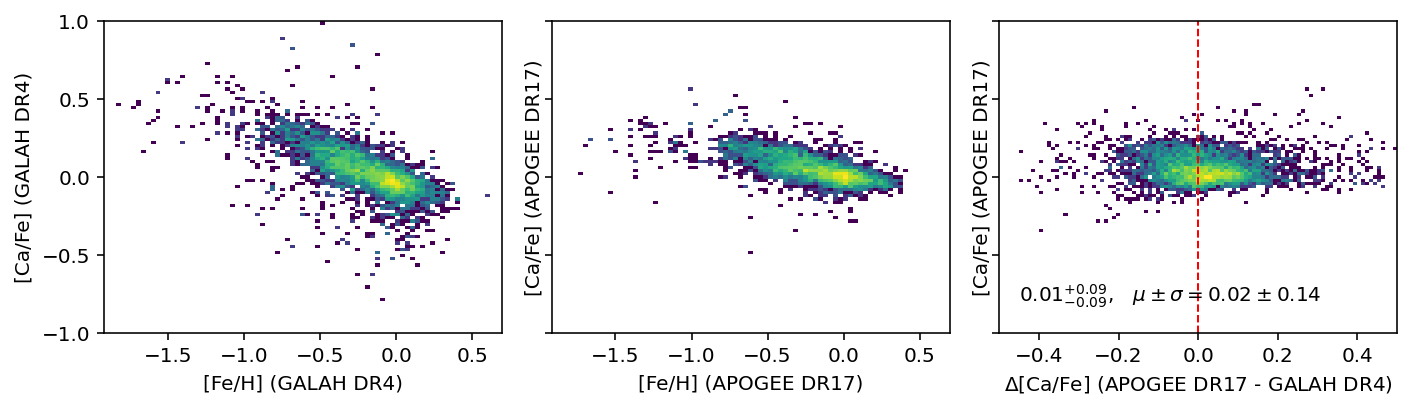

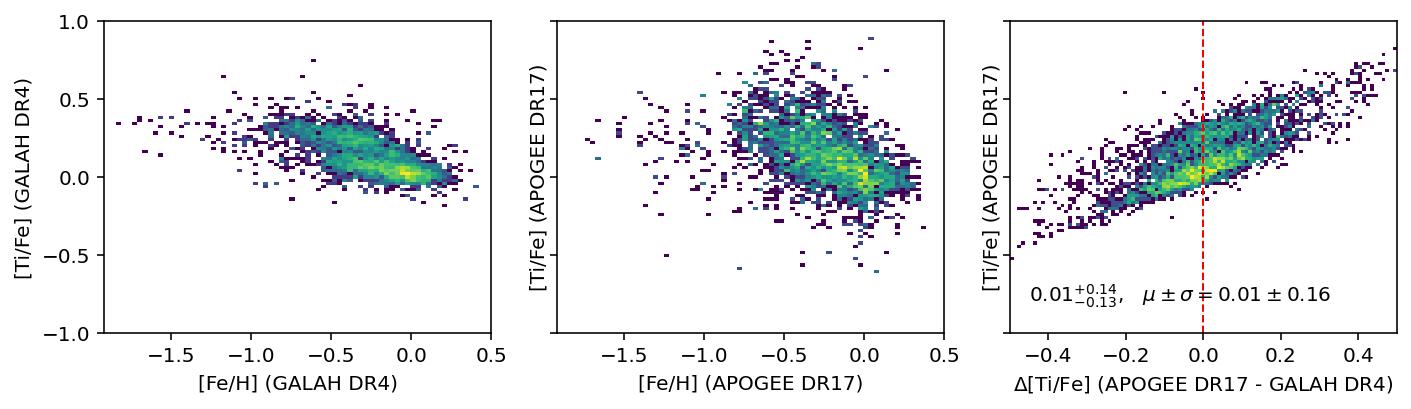

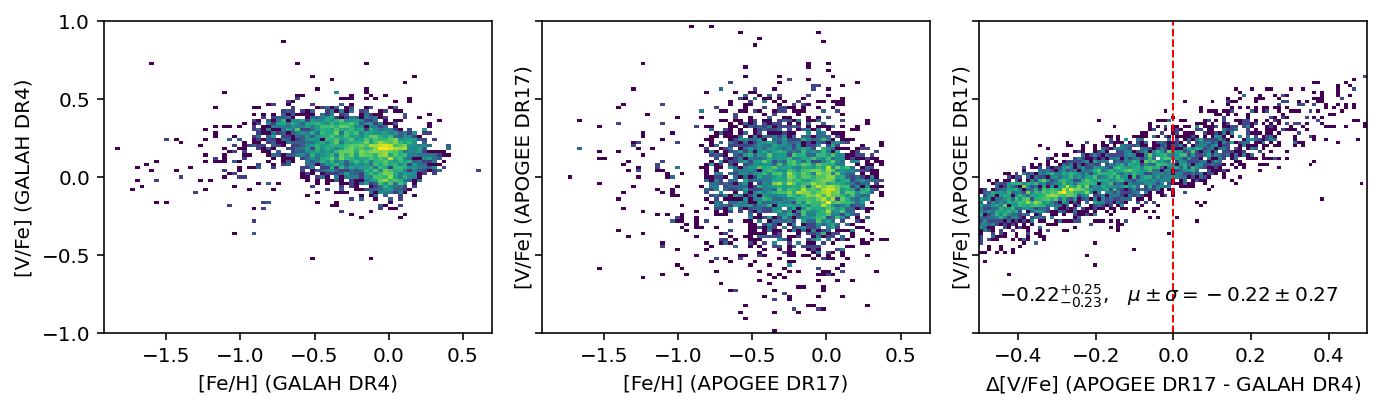

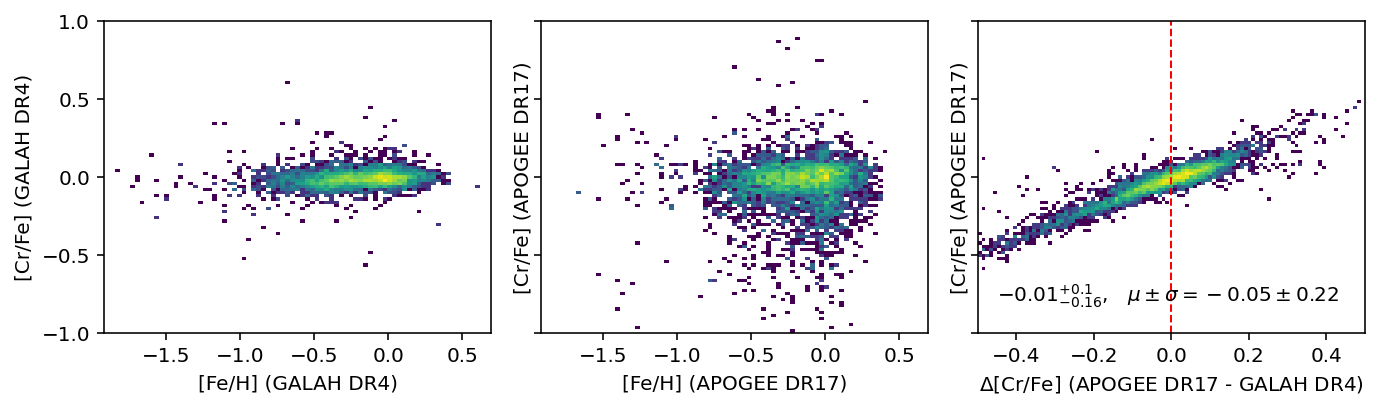

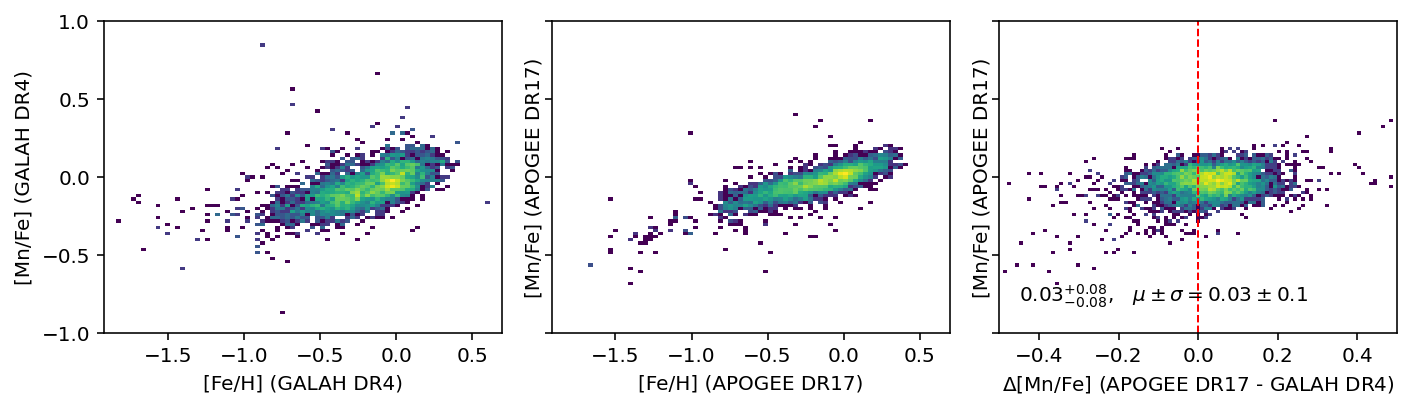

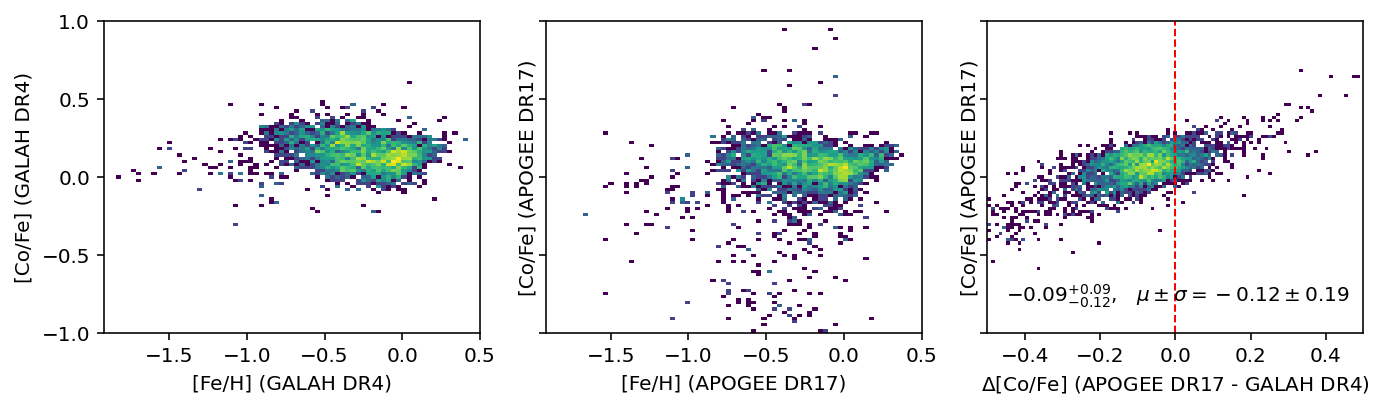

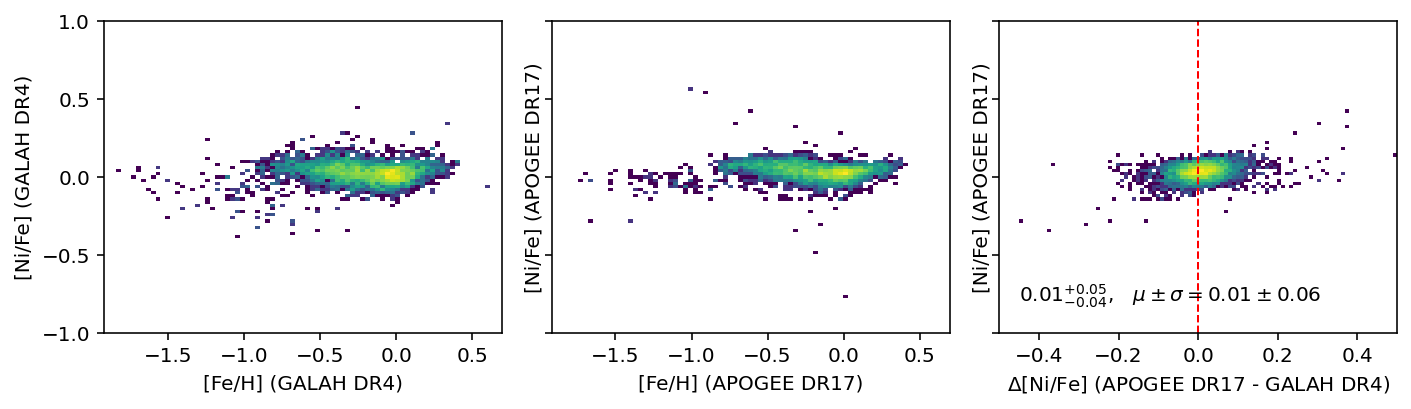

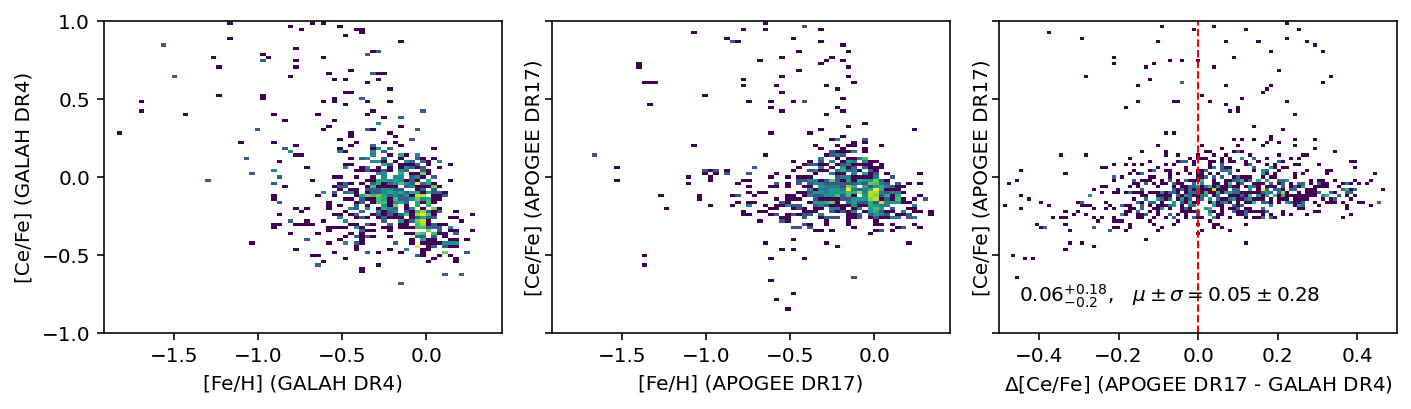

In [11]:
for element in ['C','N','O','Na','Mg','Al','Si','K','Ca','Ti','V','Cr','Mn','Co','Ni','Ce']:
    plot_comparison_xfe(joined, element = element)